In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# MANGA Dataset
---

### Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

drive  sample_data


In [4]:
# # Unzipping
!unzip /content/drive/MyDrive/animeface-character-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: animeface-character-dataset/data/face_323_149_22.png  
  inflating: animeface-character-dataset/data/face_323_149_25.png  
  inflating: animeface-character-dataset/data/face_323_149_32.png  
  inflating: animeface-character-dataset/data/face_323_149_38.png  
  inflating: animeface-character-dataset/data/face_323_149_56.png  
  inflating: animeface-character-dataset/data/face_323_149_7.png  
  inflating: animeface-character-dataset/data/face_323_149_81.png  
  inflating: animeface-character-dataset/data/face_323_174_148.png  
  inflating: animeface-character-dataset/data/face_323_174_151.png  
  inflating: animeface-character-dataset/data/face_323_174_154.png  
  inflating: animeface-character-dataset/data/face_323_174_44.png  
  inflating: animeface-character-dataset/data/face_323_174_52.png  
  inflating: animeface-character-dataset/data/face_323_174_54.png  
  inflating: animeface-character-dataset/data/face_323_174_92.p

In [5]:
!ls "$content/drive/My Drive"

ls: cannot access '/drive/My Drive': No such file or directory


In [6]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((64, 64)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = '/content/animeface-character-dataset' # change path accordingly
train_dataset = ImageFolder(PATH, transform=transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 19508
    Root location: /content/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [8]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [9]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

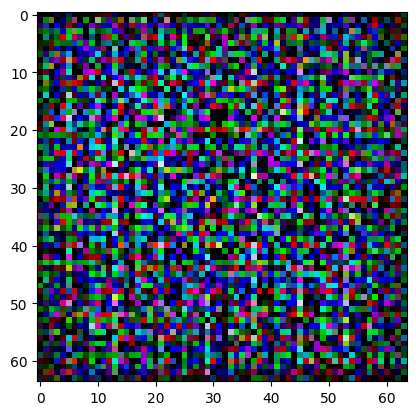

In [10]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---

In [11]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps) x 32 x 32
            nn.Conv2d(maps, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*2) x 16 x 16
            nn.Conv2d(maps * 2, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*4) x 8 x 8
            nn.Conv2d(maps * 4, maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*8) x 4 x 4
            nn.Conv2d(maps * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [12]:
# Instantiate the discriminator
discriminator = Discriminator()
output_discriminator = discriminator(output)
output_discriminator.shape

torch.Size([64, 1])

In [13]:
output.shape

torch.Size([64, 3, 64, 64])

# Training Loop
---

In [14]:
# First time running the generator and discriminator

# generator = Generator()
# discriminator = Discriminator()

In [15]:
import pickle

# Read in the generator and discriminator saved after 50 epochs
with open('/content/drive/MyDrive/generator_200.pkl', 'rb') as f:
    generator = pickle.load(f)

with open('/content/drive/MyDrive/discriminator_200.pkl', 'rb') as f:
    discriminator = pickle.load(f)

In [16]:
##### Rashmi: I wasnt sure why the train loop was in the complier model class above so tried different way below
# since we have already defined gen and disc classes we can just initialize gen, disc, optimizers, and loss
# and then run the train loop

if torch.cuda.is_available():
    print("GPU is available")
    # Print GPU device name
    print("GPU device name:", torch.cuda.get_device_name(0))  # 0 is the index of the GPU
else:
    print("GPU is not available")

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)


# Training Loop
num_epochs = 100
latent_size = 128

for epoch in tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Train the discriminator
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        d_real_loss = criterion(real_outputs, real_labels)
        fake_outputs = discriminator(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")


GPU is available
GPU device name: Tesla T4


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Step [100/610], Generator Loss: 10.4148, Discriminator Loss: 0.0038
Epoch [1/100], Step [200/610], Generator Loss: 11.1127, Discriminator Loss: 0.2727
Epoch [1/100], Step [300/610], Generator Loss: 6.3109, Discriminator Loss: 0.0325
Epoch [1/100], Step [400/610], Generator Loss: 6.9334, Discriminator Loss: 0.0133
Epoch [1/100], Step [500/610], Generator Loss: 7.2897, Discriminator Loss: 0.0116
Epoch [1/100], Step [600/610], Generator Loss: 17.8960, Discriminator Loss: 0.0045


  1%|          | 1/100 [00:47<1:17:49, 47.17s/it]

Epoch [2/100], Step [100/610], Generator Loss: 10.9288, Discriminator Loss: 0.0052
Epoch [2/100], Step [200/610], Generator Loss: 13.0320, Discriminator Loss: 0.0015
Epoch [2/100], Step [300/610], Generator Loss: 11.3528, Discriminator Loss: 0.0005
Epoch [2/100], Step [400/610], Generator Loss: 8.1058, Discriminator Loss: 0.0101
Epoch [2/100], Step [500/610], Generator Loss: 9.8985, Discriminator Loss: 0.0332
Epoch [2/100], Step [600/610], Generator Loss: 7.5869, Discriminator Loss: 0.0101


  2%|▏         | 2/100 [01:33<1:15:53, 46.46s/it]

Epoch [3/100], Step [100/610], Generator Loss: 7.2971, Discriminator Loss: 0.2828
Epoch [3/100], Step [200/610], Generator Loss: 8.5637, Discriminator Loss: 0.0033
Epoch [3/100], Step [300/610], Generator Loss: 11.0616, Discriminator Loss: 0.0111
Epoch [3/100], Step [400/610], Generator Loss: 7.5728, Discriminator Loss: 0.0364
Epoch [3/100], Step [500/610], Generator Loss: 8.0458, Discriminator Loss: 0.0031
Epoch [3/100], Step [600/610], Generator Loss: 6.5176, Discriminator Loss: 0.0796


  3%|▎         | 3/100 [02:16<1:13:03, 45.19s/it]

Epoch [4/100], Step [100/610], Generator Loss: 8.3733, Discriminator Loss: 0.0254
Epoch [4/100], Step [200/610], Generator Loss: 7.9986, Discriminator Loss: 0.0524
Epoch [4/100], Step [300/610], Generator Loss: 8.8214, Discriminator Loss: 0.0226
Epoch [4/100], Step [400/610], Generator Loss: 8.2322, Discriminator Loss: 0.0071
Epoch [4/100], Step [500/610], Generator Loss: 6.2355, Discriminator Loss: 0.0454
Epoch [4/100], Step [600/610], Generator Loss: 8.7169, Discriminator Loss: 0.0077


  4%|▍         | 4/100 [03:00<1:11:03, 44.41s/it]

Epoch [5/100], Step [100/610], Generator Loss: 11.5763, Discriminator Loss: 0.0044
Epoch [5/100], Step [200/610], Generator Loss: 11.7455, Discriminator Loss: 0.0060
Epoch [5/100], Step [300/610], Generator Loss: 7.3355, Discriminator Loss: 0.0174
Epoch [5/100], Step [400/610], Generator Loss: 10.0428, Discriminator Loss: 0.1760
Epoch [5/100], Step [500/610], Generator Loss: 9.0620, Discriminator Loss: 0.0055
Epoch [5/100], Step [600/610], Generator Loss: 7.6496, Discriminator Loss: 0.0034


  5%|▌         | 5/100 [03:44<1:10:23, 44.45s/it]

Epoch [6/100], Step [100/610], Generator Loss: 12.6617, Discriminator Loss: 0.0262
Epoch [6/100], Step [200/610], Generator Loss: 8.0613, Discriminator Loss: 0.0023
Epoch [6/100], Step [300/610], Generator Loss: 8.8135, Discriminator Loss: 0.0015
Epoch [6/100], Step [400/610], Generator Loss: 7.5319, Discriminator Loss: 0.0160
Epoch [6/100], Step [500/610], Generator Loss: 8.6122, Discriminator Loss: 0.0094
Epoch [6/100], Step [600/610], Generator Loss: 8.0792, Discriminator Loss: 0.0018


  6%|▌         | 6/100 [04:27<1:09:02, 44.07s/it]

Epoch [7/100], Step [100/610], Generator Loss: 7.8334, Discriminator Loss: 0.0155
Epoch [7/100], Step [200/610], Generator Loss: 8.6695, Discriminator Loss: 0.0066
Epoch [7/100], Step [300/610], Generator Loss: 6.6710, Discriminator Loss: 0.1639
Epoch [7/100], Step [400/610], Generator Loss: 13.0399, Discriminator Loss: 0.5532
Epoch [7/100], Step [500/610], Generator Loss: 8.6554, Discriminator Loss: 0.0069
Epoch [7/100], Step [600/610], Generator Loss: 12.1368, Discriminator Loss: 0.0822


  7%|▋         | 7/100 [05:11<1:08:15, 44.04s/it]

Epoch [8/100], Step [100/610], Generator Loss: 7.1901, Discriminator Loss: 0.0119
Epoch [8/100], Step [200/610], Generator Loss: 8.6378, Discriminator Loss: 0.0094
Epoch [8/100], Step [300/610], Generator Loss: 10.4013, Discriminator Loss: 0.0313
Epoch [8/100], Step [400/610], Generator Loss: 11.6636, Discriminator Loss: 0.0016
Epoch [8/100], Step [500/610], Generator Loss: 7.6454, Discriminator Loss: 0.0083
Epoch [8/100], Step [600/610], Generator Loss: 10.8533, Discriminator Loss: 0.0047


  8%|▊         | 8/100 [05:56<1:08:01, 44.37s/it]

Epoch [9/100], Step [100/610], Generator Loss: 9.7502, Discriminator Loss: 0.0012
Epoch [9/100], Step [200/610], Generator Loss: 6.6555, Discriminator Loss: 0.0437
Epoch [9/100], Step [300/610], Generator Loss: 6.4385, Discriminator Loss: 0.0539
Epoch [9/100], Step [400/610], Generator Loss: 11.6821, Discriminator Loss: 0.0185
Epoch [9/100], Step [500/610], Generator Loss: 8.5377, Discriminator Loss: 0.0049
Epoch [9/100], Step [600/610], Generator Loss: 6.6925, Discriminator Loss: 0.0703


  9%|▉         | 9/100 [06:40<1:06:46, 44.03s/it]

Epoch [10/100], Step [100/610], Generator Loss: 10.7598, Discriminator Loss: 0.0099
Epoch [10/100], Step [200/610], Generator Loss: 8.8468, Discriminator Loss: 0.0178
Epoch [10/100], Step [300/610], Generator Loss: 7.9744, Discriminator Loss: 0.1625
Epoch [10/100], Step [400/610], Generator Loss: 9.0776, Discriminator Loss: 0.0086
Epoch [10/100], Step [500/610], Generator Loss: 13.3921, Discriminator Loss: 0.0214
Epoch [10/100], Step [600/610], Generator Loss: 12.4805, Discriminator Loss: 0.0058


 10%|█         | 10/100 [07:23<1:05:52, 43.91s/it]

Epoch [11/100], Step [100/610], Generator Loss: 6.8496, Discriminator Loss: 0.0086
Epoch [11/100], Step [200/610], Generator Loss: 8.6012, Discriminator Loss: 0.0193
Epoch [11/100], Step [300/610], Generator Loss: 7.3369, Discriminator Loss: 0.0114
Epoch [11/100], Step [400/610], Generator Loss: 9.7677, Discriminator Loss: 0.0007
Epoch [11/100], Step [500/610], Generator Loss: 10.2269, Discriminator Loss: 0.0114
Epoch [11/100], Step [600/610], Generator Loss: 6.8045, Discriminator Loss: 0.0072


 11%|█         | 11/100 [08:07<1:05:03, 43.86s/it]

Epoch [12/100], Step [100/610], Generator Loss: 9.6519, Discriminator Loss: 0.1474
Epoch [12/100], Step [200/610], Generator Loss: 9.1199, Discriminator Loss: 0.0024
Epoch [12/100], Step [300/610], Generator Loss: 13.2304, Discriminator Loss: 0.0179
Epoch [12/100], Step [400/610], Generator Loss: 9.9094, Discriminator Loss: 0.0121
Epoch [12/100], Step [500/610], Generator Loss: 9.7984, Discriminator Loss: 0.0160
Epoch [12/100], Step [600/610], Generator Loss: 7.8747, Discriminator Loss: 0.0050


 12%|█▏        | 12/100 [08:53<1:05:05, 44.38s/it]

Epoch [13/100], Step [100/610], Generator Loss: 14.1827, Discriminator Loss: 0.0025
Epoch [13/100], Step [200/610], Generator Loss: 14.8141, Discriminator Loss: 0.0033
Epoch [13/100], Step [300/610], Generator Loss: 9.0131, Discriminator Loss: 0.0373
Epoch [13/100], Step [400/610], Generator Loss: 5.0146, Discriminator Loss: 0.0563
Epoch [13/100], Step [500/610], Generator Loss: 8.8505, Discriminator Loss: 0.0033
Epoch [13/100], Step [600/610], Generator Loss: 6.7086, Discriminator Loss: 0.0207


 13%|█▎        | 13/100 [09:36<1:03:55, 44.09s/it]

Epoch [14/100], Step [100/610], Generator Loss: 7.6332, Discriminator Loss: 0.0082
Epoch [14/100], Step [200/610], Generator Loss: 10.2046, Discriminator Loss: 0.0104
Epoch [14/100], Step [300/610], Generator Loss: 12.7547, Discriminator Loss: 0.0066
Epoch [14/100], Step [400/610], Generator Loss: 9.0789, Discriminator Loss: 0.0100
Epoch [14/100], Step [500/610], Generator Loss: 13.6914, Discriminator Loss: 0.0019
Epoch [14/100], Step [600/610], Generator Loss: 10.0555, Discriminator Loss: 0.0049


 14%|█▍        | 14/100 [10:20<1:02:59, 43.95s/it]

Epoch [15/100], Step [100/610], Generator Loss: 7.5516, Discriminator Loss: 0.0099
Epoch [15/100], Step [200/610], Generator Loss: 11.9210, Discriminator Loss: 0.0091
Epoch [15/100], Step [300/610], Generator Loss: 6.7369, Discriminator Loss: 0.0136
Epoch [15/100], Step [400/610], Generator Loss: 9.7143, Discriminator Loss: 0.0014
Epoch [15/100], Step [500/610], Generator Loss: 9.9773, Discriminator Loss: 0.0036
Epoch [15/100], Step [600/610], Generator Loss: 11.5613, Discriminator Loss: 0.0130


 15%|█▌        | 15/100 [11:05<1:02:38, 44.21s/it]

Epoch [16/100], Step [100/610], Generator Loss: 14.1065, Discriminator Loss: 0.0034
Epoch [16/100], Step [200/610], Generator Loss: 7.6620, Discriminator Loss: 0.0040
Epoch [16/100], Step [300/610], Generator Loss: 11.7029, Discriminator Loss: 0.0199
Epoch [16/100], Step [400/610], Generator Loss: 6.6587, Discriminator Loss: 0.0215
Epoch [16/100], Step [500/610], Generator Loss: 10.5530, Discriminator Loss: 0.0202
Epoch [16/100], Step [600/610], Generator Loss: 11.7757, Discriminator Loss: 0.0038


 16%|█▌        | 16/100 [11:49<1:01:56, 44.24s/it]

Epoch [17/100], Step [100/610], Generator Loss: 6.7302, Discriminator Loss: 0.0108
Epoch [17/100], Step [200/610], Generator Loss: 12.0439, Discriminator Loss: 0.0062
Epoch [17/100], Step [300/610], Generator Loss: 5.9924, Discriminator Loss: 0.1291
Epoch [17/100], Step [400/610], Generator Loss: 7.7612, Discriminator Loss: 0.0106
Epoch [17/100], Step [500/610], Generator Loss: 9.1938, Discriminator Loss: 0.0152
Epoch [17/100], Step [600/610], Generator Loss: 7.9895, Discriminator Loss: 0.0064


 17%|█▋        | 17/100 [12:33<1:01:14, 44.27s/it]

Epoch [18/100], Step [100/610], Generator Loss: 7.5753, Discriminator Loss: 0.3177
Epoch [18/100], Step [200/610], Generator Loss: 8.3805, Discriminator Loss: 0.1945
Epoch [18/100], Step [300/610], Generator Loss: 9.2926, Discriminator Loss: 0.0032
Epoch [18/100], Step [400/610], Generator Loss: 11.9136, Discriminator Loss: 0.1445
Epoch [18/100], Step [500/610], Generator Loss: 10.7285, Discriminator Loss: 0.0018
Epoch [18/100], Step [600/610], Generator Loss: 9.8212, Discriminator Loss: 0.0050


 18%|█▊        | 18/100 [13:17<1:00:09, 44.02s/it]

Epoch [19/100], Step [100/610], Generator Loss: 12.3798, Discriminator Loss: 0.0038
Epoch [19/100], Step [200/610], Generator Loss: 7.3912, Discriminator Loss: 0.0130
Epoch [19/100], Step [300/610], Generator Loss: 11.2172, Discriminator Loss: 0.0003
Epoch [19/100], Step [400/610], Generator Loss: 10.5171, Discriminator Loss: 0.0388
Epoch [19/100], Step [500/610], Generator Loss: 13.0396, Discriminator Loss: 0.0039
Epoch [19/100], Step [600/610], Generator Loss: 6.7656, Discriminator Loss: 0.0162


 19%|█▉        | 19/100 [14:01<59:38, 44.18s/it]  

Epoch [20/100], Step [100/610], Generator Loss: 8.6537, Discriminator Loss: 0.0074
Epoch [20/100], Step [200/610], Generator Loss: 13.6469, Discriminator Loss: 0.0034
Epoch [20/100], Step [300/610], Generator Loss: 5.0948, Discriminator Loss: 0.1082
Epoch [20/100], Step [400/610], Generator Loss: 9.2397, Discriminator Loss: 0.0048
Epoch [20/100], Step [500/610], Generator Loss: 16.5270, Discriminator Loss: 0.0011
Epoch [20/100], Step [600/610], Generator Loss: 7.4976, Discriminator Loss: 0.0694


 20%|██        | 20/100 [14:45<58:34, 43.94s/it]

Epoch [21/100], Step [100/610], Generator Loss: 13.1980, Discriminator Loss: 0.0028
Epoch [21/100], Step [200/610], Generator Loss: 11.8385, Discriminator Loss: 0.0018
Epoch [21/100], Step [300/610], Generator Loss: 8.9471, Discriminator Loss: 0.0295
Epoch [21/100], Step [400/610], Generator Loss: 12.9943, Discriminator Loss: 0.0035
Epoch [21/100], Step [500/610], Generator Loss: 13.7842, Discriminator Loss: 0.0061
Epoch [21/100], Step [600/610], Generator Loss: 10.0037, Discriminator Loss: 0.0014


 21%|██        | 21/100 [15:28<57:48, 43.91s/it]

Epoch [22/100], Step [100/610], Generator Loss: 9.9787, Discriminator Loss: 0.0017
Epoch [22/100], Step [200/610], Generator Loss: 10.5469, Discriminator Loss: 0.0049
Epoch [22/100], Step [300/610], Generator Loss: 8.0419, Discriminator Loss: 0.0290
Epoch [22/100], Step [400/610], Generator Loss: 11.2921, Discriminator Loss: 0.0147
Epoch [22/100], Step [500/610], Generator Loss: 9.1063, Discriminator Loss: 0.0022
Epoch [22/100], Step [600/610], Generator Loss: 6.3616, Discriminator Loss: 0.0353


 22%|██▏       | 22/100 [16:14<57:42, 44.40s/it]

Epoch [23/100], Step [100/610], Generator Loss: 4.2011, Discriminator Loss: 0.0717
Epoch [23/100], Step [200/610], Generator Loss: 9.2536, Discriminator Loss: 0.0838
Epoch [23/100], Step [300/610], Generator Loss: 15.1297, Discriminator Loss: 0.2296
Epoch [23/100], Step [400/610], Generator Loss: 17.6560, Discriminator Loss: 0.0003
Epoch [23/100], Step [500/610], Generator Loss: 8.8553, Discriminator Loss: 0.0344
Epoch [23/100], Step [600/610], Generator Loss: 7.8855, Discriminator Loss: 0.0119


 23%|██▎       | 23/100 [16:58<56:48, 44.26s/it]

Epoch [24/100], Step [100/610], Generator Loss: 11.8306, Discriminator Loss: 0.0033
Epoch [24/100], Step [200/610], Generator Loss: 12.1347, Discriminator Loss: 0.0331
Epoch [24/100], Step [300/610], Generator Loss: 12.1135, Discriminator Loss: 0.0141
Epoch [24/100], Step [400/610], Generator Loss: 12.2400, Discriminator Loss: 0.0067
Epoch [24/100], Step [500/610], Generator Loss: 8.6754, Discriminator Loss: 0.0322
Epoch [24/100], Step [600/610], Generator Loss: 6.9323, Discriminator Loss: 0.0464


 24%|██▍       | 24/100 [17:42<55:49, 44.08s/it]

Epoch [25/100], Step [100/610], Generator Loss: 13.6124, Discriminator Loss: 0.0017
Epoch [25/100], Step [200/610], Generator Loss: 6.9420, Discriminator Loss: 0.0050
Epoch [25/100], Step [300/610], Generator Loss: 12.2589, Discriminator Loss: 0.0021
Epoch [25/100], Step [400/610], Generator Loss: 16.7981, Discriminator Loss: 0.0046
Epoch [25/100], Step [500/610], Generator Loss: 10.2300, Discriminator Loss: 0.0019
Epoch [25/100], Step [600/610], Generator Loss: 14.0545, Discriminator Loss: 0.0862


 25%|██▌       | 25/100 [18:25<54:53, 43.91s/it]

Epoch [26/100], Step [100/610], Generator Loss: 7.4368, Discriminator Loss: 0.0042
Epoch [26/100], Step [200/610], Generator Loss: 9.5385, Discriminator Loss: 0.0322
Epoch [26/100], Step [300/610], Generator Loss: 9.1021, Discriminator Loss: 0.0028
Epoch [26/100], Step [400/610], Generator Loss: 9.9045, Discriminator Loss: 0.0007
Epoch [26/100], Step [500/610], Generator Loss: 6.8371, Discriminator Loss: 0.0913
Epoch [26/100], Step [600/610], Generator Loss: 15.6164, Discriminator Loss: 0.2034


 26%|██▌       | 26/100 [19:10<54:28, 44.17s/it]

Epoch [27/100], Step [100/610], Generator Loss: 12.0012, Discriminator Loss: 0.0449
Epoch [27/100], Step [200/610], Generator Loss: 10.0560, Discriminator Loss: 0.0160
Epoch [27/100], Step [300/610], Generator Loss: 10.2843, Discriminator Loss: 0.0100
Epoch [27/100], Step [400/610], Generator Loss: 13.9358, Discriminator Loss: 0.0088
Epoch [27/100], Step [500/610], Generator Loss: 9.2890, Discriminator Loss: 0.0062
Epoch [27/100], Step [600/610], Generator Loss: 7.4955, Discriminator Loss: 0.0140


 27%|██▋       | 27/100 [19:53<53:30, 43.98s/it]

Epoch [28/100], Step [100/610], Generator Loss: 11.6009, Discriminator Loss: 0.0016
Epoch [28/100], Step [200/610], Generator Loss: 1.8812, Discriminator Loss: 1.3090
Epoch [28/100], Step [300/610], Generator Loss: 15.6297, Discriminator Loss: 0.0104
Epoch [28/100], Step [400/610], Generator Loss: 7.0345, Discriminator Loss: 0.0142
Epoch [28/100], Step [500/610], Generator Loss: 8.6205, Discriminator Loss: 0.0047
Epoch [28/100], Step [600/610], Generator Loss: 11.3229, Discriminator Loss: 0.0003


 28%|██▊       | 28/100 [20:38<52:53, 44.08s/it]

Epoch [29/100], Step [100/610], Generator Loss: 11.2664, Discriminator Loss: 0.0270
Epoch [29/100], Step [200/610], Generator Loss: 14.2928, Discriminator Loss: 0.0152
Epoch [29/100], Step [300/610], Generator Loss: 17.4988, Discriminator Loss: 0.0026
Epoch [29/100], Step [400/610], Generator Loss: 8.0509, Discriminator Loss: 0.0031
Epoch [29/100], Step [500/610], Generator Loss: 7.8325, Discriminator Loss: 0.0029
Epoch [29/100], Step [600/610], Generator Loss: 13.5980, Discriminator Loss: 0.0162


 29%|██▉       | 29/100 [21:23<52:37, 44.47s/it]

Epoch [30/100], Step [100/610], Generator Loss: 8.3500, Discriminator Loss: 0.0149
Epoch [30/100], Step [200/610], Generator Loss: 10.0388, Discriminator Loss: 0.0181
Epoch [30/100], Step [300/610], Generator Loss: 10.4240, Discriminator Loss: 0.0009
Epoch [30/100], Step [400/610], Generator Loss: 8.1698, Discriminator Loss: 0.0176
Epoch [30/100], Step [500/610], Generator Loss: 14.5831, Discriminator Loss: 0.0083
Epoch [30/100], Step [600/610], Generator Loss: 13.1530, Discriminator Loss: 0.1091


 30%|███       | 30/100 [22:07<51:34, 44.21s/it]

Epoch [31/100], Step [100/610], Generator Loss: 8.3727, Discriminator Loss: 0.0055
Epoch [31/100], Step [200/610], Generator Loss: 11.9020, Discriminator Loss: 0.0217
Epoch [31/100], Step [300/610], Generator Loss: 11.2393, Discriminator Loss: 0.0091
Epoch [31/100], Step [400/610], Generator Loss: 7.1399, Discriminator Loss: 0.0064
Epoch [31/100], Step [500/610], Generator Loss: 9.3769, Discriminator Loss: 0.0183
Epoch [31/100], Step [600/610], Generator Loss: 7.9144, Discriminator Loss: 0.0316


 31%|███       | 31/100 [22:50<50:31, 43.94s/it]

Epoch [32/100], Step [100/610], Generator Loss: 12.3334, Discriminator Loss: 0.0128
Epoch [32/100], Step [200/610], Generator Loss: 13.8800, Discriminator Loss: 0.0020
Epoch [32/100], Step [300/610], Generator Loss: 17.2545, Discriminator Loss: 0.0011
Epoch [32/100], Step [400/610], Generator Loss: 7.2589, Discriminator Loss: 0.0401
Epoch [32/100], Step [500/610], Generator Loss: 12.3199, Discriminator Loss: 0.0395
Epoch [32/100], Step [600/610], Generator Loss: 12.4545, Discriminator Loss: 0.0010


 32%|███▏      | 32/100 [23:33<49:38, 43.80s/it]

Epoch [33/100], Step [100/610], Generator Loss: 13.2027, Discriminator Loss: 0.1723
Epoch [33/100], Step [200/610], Generator Loss: 15.4586, Discriminator Loss: 0.0136
Epoch [33/100], Step [300/610], Generator Loss: 6.7452, Discriminator Loss: 0.0592
Epoch [33/100], Step [400/610], Generator Loss: 9.6128, Discriminator Loss: 0.0013
Epoch [33/100], Step [500/610], Generator Loss: 10.3593, Discriminator Loss: 0.0044
Epoch [33/100], Step [600/610], Generator Loss: 21.0266, Discriminator Loss: 0.0044


 33%|███▎      | 33/100 [24:18<49:16, 44.12s/it]

Epoch [34/100], Step [100/610], Generator Loss: 10.6839, Discriminator Loss: 0.0197
Epoch [34/100], Step [200/610], Generator Loss: 8.3790, Discriminator Loss: 0.0421
Epoch [34/100], Step [300/610], Generator Loss: 5.9476, Discriminator Loss: 0.0214
Epoch [34/100], Step [400/610], Generator Loss: 9.1527, Discriminator Loss: 0.2303
Epoch [34/100], Step [500/610], Generator Loss: 7.4454, Discriminator Loss: 0.0681
Epoch [34/100], Step [600/610], Generator Loss: 10.6413, Discriminator Loss: 0.0196


 34%|███▍      | 34/100 [25:02<48:33, 44.14s/it]

Epoch [35/100], Step [100/610], Generator Loss: 13.1670, Discriminator Loss: 0.0502
Epoch [35/100], Step [200/610], Generator Loss: 10.1569, Discriminator Loss: 0.0064
Epoch [35/100], Step [300/610], Generator Loss: 15.7163, Discriminator Loss: 0.0021
Epoch [35/100], Step [400/610], Generator Loss: 17.3852, Discriminator Loss: 0.0457
Epoch [35/100], Step [500/610], Generator Loss: 18.5448, Discriminator Loss: 0.0053
Epoch [35/100], Step [600/610], Generator Loss: 6.1884, Discriminator Loss: 0.0302


 35%|███▌      | 35/100 [25:46<47:46, 44.11s/it]

Epoch [36/100], Step [100/610], Generator Loss: 14.9932, Discriminator Loss: 0.0171
Epoch [36/100], Step [200/610], Generator Loss: 13.4459, Discriminator Loss: 0.0345
Epoch [36/100], Step [300/610], Generator Loss: 10.0146, Discriminator Loss: 0.0026
Epoch [36/100], Step [400/610], Generator Loss: 14.2599, Discriminator Loss: 0.0247
Epoch [36/100], Step [500/610], Generator Loss: 13.6021, Discriminator Loss: 0.0048
Epoch [36/100], Step [600/610], Generator Loss: 10.5107, Discriminator Loss: 0.0013


 36%|███▌      | 36/100 [26:32<47:23, 44.44s/it]

Epoch [37/100], Step [100/610], Generator Loss: 10.2295, Discriminator Loss: 0.0005
Epoch [37/100], Step [200/610], Generator Loss: 8.0331, Discriminator Loss: 0.0637
Epoch [37/100], Step [300/610], Generator Loss: 9.3653, Discriminator Loss: 0.0605
Epoch [37/100], Step [400/610], Generator Loss: 9.2138, Discriminator Loss: 0.0062
Epoch [37/100], Step [500/610], Generator Loss: 12.6540, Discriminator Loss: 0.0100
Epoch [37/100], Step [600/610], Generator Loss: 16.2602, Discriminator Loss: 0.0025


 37%|███▋      | 37/100 [27:15<46:21, 44.14s/it]

Epoch [38/100], Step [100/610], Generator Loss: 11.3391, Discriminator Loss: 0.0217
Epoch [38/100], Step [200/610], Generator Loss: 11.8890, Discriminator Loss: 0.0037
Epoch [38/100], Step [300/610], Generator Loss: 12.5049, Discriminator Loss: 0.0005
Epoch [38/100], Step [400/610], Generator Loss: 11.1134, Discriminator Loss: 0.0026
Epoch [38/100], Step [500/610], Generator Loss: 6.7641, Discriminator Loss: 0.0102
Epoch [38/100], Step [600/610], Generator Loss: 7.9124, Discriminator Loss: 0.0156


 38%|███▊      | 38/100 [27:59<45:23, 43.92s/it]

Epoch [39/100], Step [100/610], Generator Loss: 7.0838, Discriminator Loss: 0.0330
Epoch [39/100], Step [200/610], Generator Loss: 8.6320, Discriminator Loss: 0.0065
Epoch [39/100], Step [300/610], Generator Loss: 11.9019, Discriminator Loss: 0.0846
Epoch [39/100], Step [400/610], Generator Loss: 12.0360, Discriminator Loss: 0.0248
Epoch [39/100], Step [500/610], Generator Loss: 10.9893, Discriminator Loss: 0.0401
Epoch [39/100], Step [600/610], Generator Loss: 7.5753, Discriminator Loss: 0.0142


 39%|███▉      | 39/100 [28:42<44:33, 43.83s/it]

Epoch [40/100], Step [100/610], Generator Loss: 12.6026, Discriminator Loss: 0.0072
Epoch [40/100], Step [200/610], Generator Loss: 8.5756, Discriminator Loss: 0.0032
Epoch [40/100], Step [300/610], Generator Loss: 8.9504, Discriminator Loss: 0.0054
Epoch [40/100], Step [400/610], Generator Loss: 8.0345, Discriminator Loss: 0.0021
Epoch [40/100], Step [500/610], Generator Loss: 14.2538, Discriminator Loss: 0.0051
Epoch [40/100], Step [600/610], Generator Loss: 10.9877, Discriminator Loss: 0.0013


 40%|████      | 40/100 [29:28<44:25, 44.43s/it]

Epoch [41/100], Step [100/610], Generator Loss: 8.9300, Discriminator Loss: 0.0014
Epoch [41/100], Step [200/610], Generator Loss: 16.4221, Discriminator Loss: 0.0015
Epoch [41/100], Step [300/610], Generator Loss: 12.2295, Discriminator Loss: 0.0019
Epoch [41/100], Step [400/610], Generator Loss: 8.1093, Discriminator Loss: 0.0035
Epoch [41/100], Step [500/610], Generator Loss: 9.5945, Discriminator Loss: 0.0017
Epoch [41/100], Step [600/610], Generator Loss: 18.8090, Discriminator Loss: 0.2120


 41%|████      | 41/100 [30:11<43:23, 44.13s/it]

Epoch [42/100], Step [100/610], Generator Loss: 9.0345, Discriminator Loss: 0.0014
Epoch [42/100], Step [200/610], Generator Loss: 13.0805, Discriminator Loss: 0.0165
Epoch [42/100], Step [300/610], Generator Loss: 8.2490, Discriminator Loss: 0.0092
Epoch [42/100], Step [400/610], Generator Loss: 13.5701, Discriminator Loss: 0.0039
Epoch [42/100], Step [500/610], Generator Loss: 8.4079, Discriminator Loss: 0.0485
Epoch [42/100], Step [600/610], Generator Loss: 14.2936, Discriminator Loss: 0.0069


 42%|████▏     | 42/100 [30:55<42:28, 43.94s/it]

Epoch [43/100], Step [100/610], Generator Loss: 10.6278, Discriminator Loss: 0.0327
Epoch [43/100], Step [200/610], Generator Loss: 8.4942, Discriminator Loss: 0.0420
Epoch [43/100], Step [300/610], Generator Loss: 8.6381, Discriminator Loss: 0.0045
Epoch [43/100], Step [400/610], Generator Loss: 12.4723, Discriminator Loss: 0.0116
Epoch [43/100], Step [500/610], Generator Loss: 13.2010, Discriminator Loss: 0.1209
Epoch [43/100], Step [600/610], Generator Loss: 10.8140, Discriminator Loss: 0.0122


 43%|████▎     | 43/100 [31:39<41:53, 44.10s/it]

Epoch [44/100], Step [100/610], Generator Loss: 14.7284, Discriminator Loss: 0.0027
Epoch [44/100], Step [200/610], Generator Loss: 8.7828, Discriminator Loss: 0.0145
Epoch [44/100], Step [300/610], Generator Loss: 13.3564, Discriminator Loss: 0.0030
Epoch [44/100], Step [400/610], Generator Loss: 4.9340, Discriminator Loss: 0.0839
Epoch [44/100], Step [500/610], Generator Loss: 9.7047, Discriminator Loss: 0.0432
Epoch [44/100], Step [600/610], Generator Loss: 6.3783, Discriminator Loss: 0.0382


 44%|████▍     | 44/100 [32:23<41:01, 43.95s/it]

Epoch [45/100], Step [100/610], Generator Loss: 7.4188, Discriminator Loss: 0.0110
Epoch [45/100], Step [200/610], Generator Loss: 13.0724, Discriminator Loss: 0.0030
Epoch [45/100], Step [300/610], Generator Loss: 10.2403, Discriminator Loss: 0.0045
Epoch [45/100], Step [400/610], Generator Loss: 13.2729, Discriminator Loss: 0.0155
Epoch [45/100], Step [500/610], Generator Loss: 8.4459, Discriminator Loss: 0.0028
Epoch [45/100], Step [600/610], Generator Loss: 4.9129, Discriminator Loss: 0.1010


 45%|████▌     | 45/100 [33:07<40:19, 43.98s/it]

Epoch [46/100], Step [100/610], Generator Loss: 8.9187, Discriminator Loss: 0.0039
Epoch [46/100], Step [200/610], Generator Loss: 18.3299, Discriminator Loss: 0.0761
Epoch [46/100], Step [300/610], Generator Loss: 12.1493, Discriminator Loss: 0.0130
Epoch [46/100], Step [400/610], Generator Loss: 10.8504, Discriminator Loss: 0.0196
Epoch [46/100], Step [500/610], Generator Loss: 13.1033, Discriminator Loss: 0.0098
Epoch [46/100], Step [600/610], Generator Loss: 20.1555, Discriminator Loss: 0.0016


 46%|████▌     | 46/100 [33:50<39:25, 43.80s/it]

Epoch [47/100], Step [100/610], Generator Loss: 15.4682, Discriminator Loss: 0.0247
Epoch [47/100], Step [200/610], Generator Loss: 8.9606, Discriminator Loss: 0.0032
Epoch [47/100], Step [300/610], Generator Loss: 10.7203, Discriminator Loss: 0.0079
Epoch [47/100], Step [400/610], Generator Loss: 11.5492, Discriminator Loss: 0.0059
Epoch [47/100], Step [500/610], Generator Loss: 17.0607, Discriminator Loss: 0.0062
Epoch [47/100], Step [600/610], Generator Loss: 9.7741, Discriminator Loss: 0.0014


 47%|████▋     | 47/100 [34:35<38:55, 44.08s/it]

Epoch [48/100], Step [100/610], Generator Loss: 10.9026, Discriminator Loss: 0.0020
Epoch [48/100], Step [200/610], Generator Loss: 11.1766, Discriminator Loss: 0.0004
Epoch [48/100], Step [300/610], Generator Loss: 8.2297, Discriminator Loss: 0.0252
Epoch [48/100], Step [400/610], Generator Loss: 17.4604, Discriminator Loss: 0.0055
Epoch [48/100], Step [500/610], Generator Loss: 7.6185, Discriminator Loss: 0.0338
Epoch [48/100], Step [600/610], Generator Loss: 13.7412, Discriminator Loss: 0.0064


 48%|████▊     | 48/100 [35:18<37:59, 43.84s/it]

Epoch [49/100], Step [100/610], Generator Loss: 7.6098, Discriminator Loss: 0.0084
Epoch [49/100], Step [200/610], Generator Loss: 13.5976, Discriminator Loss: 0.0109
Epoch [49/100], Step [300/610], Generator Loss: 8.5137, Discriminator Loss: 0.0503
Epoch [49/100], Step [400/610], Generator Loss: 15.5830, Discriminator Loss: 0.0060
Epoch [49/100], Step [500/610], Generator Loss: 6.8172, Discriminator Loss: 0.1598
Epoch [49/100], Step [600/610], Generator Loss: 9.7679, Discriminator Loss: 0.0234


 49%|████▉     | 49/100 [36:02<37:08, 43.69s/it]

Epoch [50/100], Step [100/610], Generator Loss: 7.6965, Discriminator Loss: 0.0600
Epoch [50/100], Step [200/610], Generator Loss: 14.7151, Discriminator Loss: 0.0181
Epoch [50/100], Step [300/610], Generator Loss: 10.5106, Discriminator Loss: 0.0247
Epoch [50/100], Step [400/610], Generator Loss: 11.6263, Discriminator Loss: 0.0046
Epoch [50/100], Step [500/610], Generator Loss: 9.0636, Discriminator Loss: 0.0074
Epoch [50/100], Step [600/610], Generator Loss: 12.2003, Discriminator Loss: 0.0076


 50%|█████     | 50/100 [36:47<36:42, 44.05s/it]

Epoch [51/100], Step [100/610], Generator Loss: 4.3214, Discriminator Loss: 0.1179
Epoch [51/100], Step [200/610], Generator Loss: 11.9462, Discriminator Loss: 0.0276
Epoch [51/100], Step [300/610], Generator Loss: 12.0446, Discriminator Loss: 0.0039
Epoch [51/100], Step [400/610], Generator Loss: 6.0679, Discriminator Loss: 0.0283
Epoch [51/100], Step [500/610], Generator Loss: 11.2581, Discriminator Loss: 0.0165
Epoch [51/100], Step [600/610], Generator Loss: 13.9478, Discriminator Loss: 0.0063


 51%|█████     | 51/100 [37:31<35:56, 44.01s/it]

Epoch [52/100], Step [100/610], Generator Loss: 7.1938, Discriminator Loss: 0.0412
Epoch [52/100], Step [200/610], Generator Loss: 8.4779, Discriminator Loss: 0.0492
Epoch [52/100], Step [300/610], Generator Loss: 10.3733, Discriminator Loss: 0.0037
Epoch [52/100], Step [400/610], Generator Loss: 22.1996, Discriminator Loss: 0.0022
Epoch [52/100], Step [500/610], Generator Loss: 8.8540, Discriminator Loss: 0.3151
Epoch [52/100], Step [600/610], Generator Loss: 8.8338, Discriminator Loss: 0.0067


 52%|█████▏    | 52/100 [38:14<35:03, 43.81s/it]

Epoch [53/100], Step [100/610], Generator Loss: 19.8963, Discriminator Loss: 0.1594
Epoch [53/100], Step [200/610], Generator Loss: 9.1873, Discriminator Loss: 0.0030
Epoch [53/100], Step [300/610], Generator Loss: 7.7561, Discriminator Loss: 0.0068
Epoch [53/100], Step [400/610], Generator Loss: 9.8589, Discriminator Loss: 0.0086
Epoch [53/100], Step [500/610], Generator Loss: 13.3237, Discriminator Loss: 0.0032
Epoch [53/100], Step [600/610], Generator Loss: 8.7511, Discriminator Loss: 0.0057


 53%|█████▎    | 53/100 [38:57<34:11, 43.66s/it]

Epoch [54/100], Step [100/610], Generator Loss: 9.5069, Discriminator Loss: 0.0073
Epoch [54/100], Step [200/610], Generator Loss: 8.5772, Discriminator Loss: 0.0027
Epoch [54/100], Step [300/610], Generator Loss: 16.6027, Discriminator Loss: 0.0003
Epoch [54/100], Step [400/610], Generator Loss: 9.4883, Discriminator Loss: 0.0030
Epoch [54/100], Step [500/610], Generator Loss: 6.6809, Discriminator Loss: 0.0376
Epoch [54/100], Step [600/610], Generator Loss: 10.0233, Discriminator Loss: 0.0164


 54%|█████▍    | 54/100 [39:42<33:41, 43.93s/it]

Epoch [55/100], Step [100/610], Generator Loss: 14.2518, Discriminator Loss: 0.0057
Epoch [55/100], Step [200/610], Generator Loss: 8.9548, Discriminator Loss: 0.0294
Epoch [55/100], Step [300/610], Generator Loss: 8.3774, Discriminator Loss: 0.1059
Epoch [55/100], Step [400/610], Generator Loss: 10.4153, Discriminator Loss: 0.0139
Epoch [55/100], Step [500/610], Generator Loss: 8.6713, Discriminator Loss: 0.0126
Epoch [55/100], Step [600/610], Generator Loss: 10.8993, Discriminator Loss: 0.0153


 55%|█████▌    | 55/100 [40:25<32:51, 43.81s/it]

Epoch [56/100], Step [100/610], Generator Loss: 11.5203, Discriminator Loss: 0.0074
Epoch [56/100], Step [200/610], Generator Loss: 8.6500, Discriminator Loss: 0.0143
Epoch [56/100], Step [300/610], Generator Loss: 11.1710, Discriminator Loss: 0.0005
Epoch [56/100], Step [400/610], Generator Loss: 6.8800, Discriminator Loss: 0.0087
Epoch [56/100], Step [500/610], Generator Loss: 14.6122, Discriminator Loss: 0.0052
Epoch [56/100], Step [600/610], Generator Loss: 11.9701, Discriminator Loss: 0.0018


 56%|█████▌    | 56/100 [41:10<32:13, 43.93s/it]

Epoch [57/100], Step [100/610], Generator Loss: 19.8254, Discriminator Loss: 0.4506
Epoch [57/100], Step [200/610], Generator Loss: 8.4357, Discriminator Loss: 0.0082
Epoch [57/100], Step [300/610], Generator Loss: 9.6060, Discriminator Loss: 0.0072
Epoch [57/100], Step [400/610], Generator Loss: 8.8223, Discriminator Loss: 0.0075
Epoch [57/100], Step [500/610], Generator Loss: 7.5702, Discriminator Loss: 0.0090
Epoch [57/100], Step [600/610], Generator Loss: 7.8283, Discriminator Loss: 0.0047


 57%|█████▋    | 57/100 [41:54<31:40, 44.20s/it]

Epoch [58/100], Step [100/610], Generator Loss: 7.6784, Discriminator Loss: 0.0221
Epoch [58/100], Step [200/610], Generator Loss: 11.5870, Discriminator Loss: 0.1391
Epoch [58/100], Step [300/610], Generator Loss: 13.4630, Discriminator Loss: 0.0142
Epoch [58/100], Step [400/610], Generator Loss: 12.5716, Discriminator Loss: 0.0128
Epoch [58/100], Step [500/610], Generator Loss: 8.1268, Discriminator Loss: 0.0048
Epoch [58/100], Step [600/610], Generator Loss: 9.2462, Discriminator Loss: 0.0029


 58%|█████▊    | 58/100 [42:37<30:42, 43.87s/it]

Epoch [59/100], Step [100/610], Generator Loss: 10.1907, Discriminator Loss: 0.0034
Epoch [59/100], Step [200/610], Generator Loss: 8.1322, Discriminator Loss: 0.0212
Epoch [59/100], Step [300/610], Generator Loss: 10.8665, Discriminator Loss: 0.0106
Epoch [59/100], Step [400/610], Generator Loss: 9.8278, Discriminator Loss: 0.0010
Epoch [59/100], Step [500/610], Generator Loss: 15.5869, Discriminator Loss: 0.0050
Epoch [59/100], Step [600/610], Generator Loss: 13.8858, Discriminator Loss: 0.0006


 59%|█████▉    | 59/100 [43:20<29:47, 43.60s/it]

Epoch [60/100], Step [100/610], Generator Loss: 12.3790, Discriminator Loss: 0.0019
Epoch [60/100], Step [200/610], Generator Loss: 8.3515, Discriminator Loss: 0.0031
Epoch [60/100], Step [300/610], Generator Loss: 10.7028, Discriminator Loss: 0.0016
Epoch [60/100], Step [400/610], Generator Loss: 12.3620, Discriminator Loss: 0.0027
Epoch [60/100], Step [500/610], Generator Loss: 18.8025, Discriminator Loss: 0.0019
Epoch [60/100], Step [600/610], Generator Loss: 11.5019, Discriminator Loss: 0.0034


 60%|██████    | 60/100 [44:04<29:00, 43.51s/it]

Epoch [61/100], Step [100/610], Generator Loss: 11.2751, Discriminator Loss: 0.0494
Epoch [61/100], Step [200/610], Generator Loss: 12.7839, Discriminator Loss: 0.0043
Epoch [61/100], Step [300/610], Generator Loss: 7.5553, Discriminator Loss: 0.0046
Epoch [61/100], Step [400/610], Generator Loss: 8.5572, Discriminator Loss: 0.0361
Epoch [61/100], Step [500/610], Generator Loss: 7.2037, Discriminator Loss: 0.0091
Epoch [61/100], Step [600/610], Generator Loss: 15.7309, Discriminator Loss: 0.0095


 61%|██████    | 61/100 [44:49<28:39, 44.09s/it]

Epoch [62/100], Step [100/610], Generator Loss: 11.7967, Discriminator Loss: 0.3794
Epoch [62/100], Step [200/610], Generator Loss: 12.9068, Discriminator Loss: 0.0250
Epoch [62/100], Step [300/610], Generator Loss: 9.6999, Discriminator Loss: 0.0036
Epoch [62/100], Step [400/610], Generator Loss: 7.2496, Discriminator Loss: 0.0267
Epoch [62/100], Step [500/610], Generator Loss: 15.8765, Discriminator Loss: 0.0199
Epoch [62/100], Step [600/610], Generator Loss: 12.6801, Discriminator Loss: 0.0048


 62%|██████▏   | 62/100 [45:32<27:46, 43.85s/it]

Epoch [63/100], Step [100/610], Generator Loss: 12.8927, Discriminator Loss: 0.0103
Epoch [63/100], Step [200/610], Generator Loss: 12.1869, Discriminator Loss: 0.0056
Epoch [63/100], Step [300/610], Generator Loss: 5.7265, Discriminator Loss: 0.0634
Epoch [63/100], Step [400/610], Generator Loss: 6.1621, Discriminator Loss: 0.0193
Epoch [63/100], Step [500/610], Generator Loss: 11.5544, Discriminator Loss: 0.0096
Epoch [63/100], Step [600/610], Generator Loss: 12.8197, Discriminator Loss: 0.0082


 63%|██████▎   | 63/100 [46:16<26:56, 43.69s/it]

Epoch [64/100], Step [100/610], Generator Loss: 10.1320, Discriminator Loss: 0.0187
Epoch [64/100], Step [200/610], Generator Loss: 7.3887, Discriminator Loss: 0.0128
Epoch [64/100], Step [300/610], Generator Loss: 11.0127, Discriminator Loss: 0.0044
Epoch [64/100], Step [400/610], Generator Loss: 9.4440, Discriminator Loss: 0.0047
Epoch [64/100], Step [500/610], Generator Loss: 14.1180, Discriminator Loss: 0.0008
Epoch [64/100], Step [600/610], Generator Loss: 8.9474, Discriminator Loss: 0.0054


 64%|██████▍   | 64/100 [46:59<26:09, 43.59s/it]

Epoch [65/100], Step [100/610], Generator Loss: 13.6485, Discriminator Loss: 0.0018
Epoch [65/100], Step [200/610], Generator Loss: 13.3275, Discriminator Loss: 0.0023
Epoch [65/100], Step [300/610], Generator Loss: 7.3105, Discriminator Loss: 0.0034
Epoch [65/100], Step [400/610], Generator Loss: 9.4851, Discriminator Loss: 0.0213
Epoch [65/100], Step [500/610], Generator Loss: 6.1766, Discriminator Loss: 0.0098
Epoch [65/100], Step [600/610], Generator Loss: 8.6092, Discriminator Loss: 0.0027


 65%|██████▌   | 65/100 [47:44<25:36, 43.89s/it]

Epoch [66/100], Step [100/610], Generator Loss: 7.5877, Discriminator Loss: 0.0757
Epoch [66/100], Step [200/610], Generator Loss: 9.4620, Discriminator Loss: 0.0025
Epoch [66/100], Step [300/610], Generator Loss: 10.5789, Discriminator Loss: 0.0067
Epoch [66/100], Step [400/610], Generator Loss: 12.4197, Discriminator Loss: 0.1577
Epoch [66/100], Step [500/610], Generator Loss: 14.1234, Discriminator Loss: 0.0021
Epoch [66/100], Step [600/610], Generator Loss: 7.6621, Discriminator Loss: 0.0137


 66%|██████▌   | 66/100 [48:27<24:46, 43.72s/it]

Epoch [67/100], Step [100/610], Generator Loss: 21.4137, Discriminator Loss: 0.0359
Epoch [67/100], Step [200/610], Generator Loss: 11.1307, Discriminator Loss: 0.0374
Epoch [67/100], Step [300/610], Generator Loss: 10.9110, Discriminator Loss: 0.0030
Epoch [67/100], Step [400/610], Generator Loss: 18.1472, Discriminator Loss: 0.0052
Epoch [67/100], Step [500/610], Generator Loss: 10.5802, Discriminator Loss: 0.0008
Epoch [67/100], Step [600/610], Generator Loss: 8.5897, Discriminator Loss: 0.0183


 67%|██████▋   | 67/100 [49:11<24:05, 43.82s/it]

Epoch [68/100], Step [100/610], Generator Loss: 12.1728, Discriminator Loss: 0.0142
Epoch [68/100], Step [200/610], Generator Loss: 9.9645, Discriminator Loss: 0.0193
Epoch [68/100], Step [300/610], Generator Loss: 14.1310, Discriminator Loss: 0.0090
Epoch [68/100], Step [400/610], Generator Loss: 7.9755, Discriminator Loss: 0.0039
Epoch [68/100], Step [500/610], Generator Loss: 12.1224, Discriminator Loss: 0.0465
Epoch [68/100], Step [600/610], Generator Loss: 9.0686, Discriminator Loss: 0.0012


 68%|██████▊   | 68/100 [49:55<23:27, 43.98s/it]

Epoch [69/100], Step [100/610], Generator Loss: 14.8581, Discriminator Loss: 0.0015
Epoch [69/100], Step [200/610], Generator Loss: 15.6770, Discriminator Loss: 0.0075
Epoch [69/100], Step [300/610], Generator Loss: 8.0359, Discriminator Loss: 0.0057
Epoch [69/100], Step [400/610], Generator Loss: 12.0469, Discriminator Loss: 0.0202
Epoch [69/100], Step [500/610], Generator Loss: 13.1826, Discriminator Loss: 0.0064
Epoch [69/100], Step [600/610], Generator Loss: 8.7884, Discriminator Loss: 0.0103


 69%|██████▉   | 69/100 [50:39<22:35, 43.73s/it]

Epoch [70/100], Step [100/610], Generator Loss: 8.3083, Discriminator Loss: 0.0673
Epoch [70/100], Step [200/610], Generator Loss: 13.9339, Discriminator Loss: 0.0024
Epoch [70/100], Step [300/610], Generator Loss: 7.6489, Discriminator Loss: 0.0086
Epoch [70/100], Step [400/610], Generator Loss: 12.2986, Discriminator Loss: 0.0110
Epoch [70/100], Step [500/610], Generator Loss: 5.8683, Discriminator Loss: 0.0268
Epoch [70/100], Step [600/610], Generator Loss: 14.6793, Discriminator Loss: 0.0040


 70%|███████   | 70/100 [51:22<21:47, 43.60s/it]

Epoch [71/100], Step [100/610], Generator Loss: 8.5418, Discriminator Loss: 0.0022
Epoch [71/100], Step [200/610], Generator Loss: 9.6609, Discriminator Loss: 0.0065
Epoch [71/100], Step [300/610], Generator Loss: 13.2965, Discriminator Loss: 0.0031
Epoch [71/100], Step [400/610], Generator Loss: 10.0674, Discriminator Loss: 0.0030
Epoch [71/100], Step [500/610], Generator Loss: 11.5072, Discriminator Loss: 0.0006
Epoch [71/100], Step [600/610], Generator Loss: 10.2571, Discriminator Loss: 0.0020


 71%|███████   | 71/100 [52:05<21:01, 43.49s/it]

Epoch [72/100], Step [100/610], Generator Loss: 10.0359, Discriminator Loss: 0.0177
Epoch [72/100], Step [200/610], Generator Loss: 7.8478, Discriminator Loss: 0.0031
Epoch [72/100], Step [300/610], Generator Loss: 9.4042, Discriminator Loss: 0.0625
Epoch [72/100], Step [400/610], Generator Loss: 9.5531, Discriminator Loss: 0.0064
Epoch [72/100], Step [500/610], Generator Loss: 14.7809, Discriminator Loss: 0.0042
Epoch [72/100], Step [600/610], Generator Loss: 7.4436, Discriminator Loss: 0.0227


 72%|███████▏  | 72/100 [52:51<20:35, 44.13s/it]

Epoch [73/100], Step [100/610], Generator Loss: 9.2683, Discriminator Loss: 0.0031
Epoch [73/100], Step [200/610], Generator Loss: 8.6689, Discriminator Loss: 0.0042
Epoch [73/100], Step [300/610], Generator Loss: 14.2767, Discriminator Loss: 0.0195
Epoch [73/100], Step [400/610], Generator Loss: 9.6768, Discriminator Loss: 0.0437
Epoch [73/100], Step [500/610], Generator Loss: 12.1738, Discriminator Loss: 0.0068
Epoch [73/100], Step [600/610], Generator Loss: 6.6889, Discriminator Loss: 0.0405


 73%|███████▎  | 73/100 [53:34<19:44, 43.87s/it]

Epoch [74/100], Step [100/610], Generator Loss: 12.5020, Discriminator Loss: 0.0099
Epoch [74/100], Step [200/610], Generator Loss: 13.4800, Discriminator Loss: 0.0053
Epoch [74/100], Step [300/610], Generator Loss: 20.5998, Discriminator Loss: 0.0019
Epoch [74/100], Step [400/610], Generator Loss: 15.8897, Discriminator Loss: 0.0437
Epoch [74/100], Step [500/610], Generator Loss: 8.8082, Discriminator Loss: 0.0052
Epoch [74/100], Step [600/610], Generator Loss: 14.3840, Discriminator Loss: 0.0015


 74%|███████▍  | 74/100 [54:17<18:55, 43.68s/it]

Epoch [75/100], Step [100/610], Generator Loss: 12.1465, Discriminator Loss: 0.0066
Epoch [75/100], Step [200/610], Generator Loss: 9.4183, Discriminator Loss: 0.0027
Epoch [75/100], Step [300/610], Generator Loss: 10.9644, Discriminator Loss: 0.0034
Epoch [75/100], Step [400/610], Generator Loss: 6.6233, Discriminator Loss: 0.3115
Epoch [75/100], Step [500/610], Generator Loss: 14.0456, Discriminator Loss: 0.1098
Epoch [75/100], Step [600/610], Generator Loss: 13.9250, Discriminator Loss: 0.0120


 75%|███████▌  | 75/100 [55:01<18:09, 43.56s/it]

Epoch [76/100], Step [100/610], Generator Loss: 7.5675, Discriminator Loss: 0.0033
Epoch [76/100], Step [200/610], Generator Loss: 9.2477, Discriminator Loss: 0.0215
Epoch [76/100], Step [300/610], Generator Loss: 12.7138, Discriminator Loss: 0.0035
Epoch [76/100], Step [400/610], Generator Loss: 9.4741, Discriminator Loss: 0.0005
Epoch [76/100], Step [500/610], Generator Loss: 8.0980, Discriminator Loss: 0.0679
Epoch [76/100], Step [600/610], Generator Loss: 2.8441, Discriminator Loss: 6.2536


 76%|███████▌  | 76/100 [55:45<17:32, 43.84s/it]

Epoch [77/100], Step [100/610], Generator Loss: 8.1941, Discriminator Loss: 0.0220
Epoch [77/100], Step [200/610], Generator Loss: 8.1284, Discriminator Loss: 0.0159
Epoch [77/100], Step [300/610], Generator Loss: 10.8105, Discriminator Loss: 0.0052
Epoch [77/100], Step [400/610], Generator Loss: 9.3216, Discriminator Loss: 0.0183
Epoch [77/100], Step [500/610], Generator Loss: 9.1256, Discriminator Loss: 0.0156
Epoch [77/100], Step [600/610], Generator Loss: 8.9305, Discriminator Loss: 0.0130


 77%|███████▋  | 77/100 [56:29<16:49, 43.88s/it]

Epoch [78/100], Step [100/610], Generator Loss: 8.2092, Discriminator Loss: 0.0056
Epoch [78/100], Step [200/610], Generator Loss: 13.6671, Discriminator Loss: 0.0398
Epoch [78/100], Step [300/610], Generator Loss: 15.1560, Discriminator Loss: 0.0203
Epoch [78/100], Step [400/610], Generator Loss: 8.1042, Discriminator Loss: 0.0120
Epoch [78/100], Step [500/610], Generator Loss: 9.3138, Discriminator Loss: 0.0063
Epoch [78/100], Step [600/610], Generator Loss: 17.5869, Discriminator Loss: 0.0284


 78%|███████▊  | 78/100 [57:13<16:03, 43.80s/it]

Epoch [79/100], Step [100/610], Generator Loss: 12.9226, Discriminator Loss: 0.0016
Epoch [79/100], Step [200/610], Generator Loss: 12.0418, Discriminator Loss: 0.0015
Epoch [79/100], Step [300/610], Generator Loss: 13.5378, Discriminator Loss: 0.0087
Epoch [79/100], Step [400/610], Generator Loss: 11.8624, Discriminator Loss: 0.0045
Epoch [79/100], Step [500/610], Generator Loss: 19.3335, Discriminator Loss: 0.0074
Epoch [79/100], Step [600/610], Generator Loss: 12.2426, Discriminator Loss: 0.0284


 79%|███████▉  | 79/100 [57:57<15:24, 44.01s/it]

Epoch [80/100], Step [100/610], Generator Loss: 11.8726, Discriminator Loss: 0.1029
Epoch [80/100], Step [200/610], Generator Loss: 9.1538, Discriminator Loss: 0.0061
Epoch [80/100], Step [300/610], Generator Loss: 11.8601, Discriminator Loss: 0.0268
Epoch [80/100], Step [400/610], Generator Loss: 15.1598, Discriminator Loss: 0.0325
Epoch [80/100], Step [500/610], Generator Loss: 14.0881, Discriminator Loss: 0.0018
Epoch [80/100], Step [600/610], Generator Loss: 8.9107, Discriminator Loss: 0.0049


 80%|████████  | 80/100 [58:40<14:35, 43.79s/it]

Epoch [81/100], Step [100/610], Generator Loss: 11.4188, Discriminator Loss: 0.0368
Epoch [81/100], Step [200/610], Generator Loss: 11.3007, Discriminator Loss: 0.0107
Epoch [81/100], Step [300/610], Generator Loss: 6.9828, Discriminator Loss: 0.0205
Epoch [81/100], Step [400/610], Generator Loss: 9.5327, Discriminator Loss: 0.0015
Epoch [81/100], Step [500/610], Generator Loss: 11.8700, Discriminator Loss: 0.0201
Epoch [81/100], Step [600/610], Generator Loss: 10.2951, Discriminator Loss: 0.0011


 81%|████████  | 81/100 [59:24<13:48, 43.60s/it]

Epoch [82/100], Step [100/610], Generator Loss: 12.1342, Discriminator Loss: 0.0014
Epoch [82/100], Step [200/610], Generator Loss: 14.3505, Discriminator Loss: 0.0028
Epoch [82/100], Step [300/610], Generator Loss: 13.8910, Discriminator Loss: 0.1830
Epoch [82/100], Step [400/610], Generator Loss: 7.4324, Discriminator Loss: 0.0489
Epoch [82/100], Step [500/610], Generator Loss: 13.6184, Discriminator Loss: 0.0014
Epoch [82/100], Step [600/610], Generator Loss: 7.6272, Discriminator Loss: 0.0305


 82%|████████▏ | 82/100 [1:00:07<13:04, 43.61s/it]

Epoch [83/100], Step [100/610], Generator Loss: 7.9540, Discriminator Loss: 0.0098
Epoch [83/100], Step [200/610], Generator Loss: 11.9686, Discriminator Loss: 0.0028
Epoch [83/100], Step [300/610], Generator Loss: 10.7584, Discriminator Loss: 0.0046
Epoch [83/100], Step [400/610], Generator Loss: 13.2411, Discriminator Loss: 0.0046
Epoch [83/100], Step [500/610], Generator Loss: 12.3414, Discriminator Loss: 0.0038
Epoch [83/100], Step [600/610], Generator Loss: 10.4434, Discriminator Loss: 0.0085


 83%|████████▎ | 83/100 [1:00:53<12:31, 44.18s/it]

Epoch [84/100], Step [100/610], Generator Loss: 16.2413, Discriminator Loss: 0.0113
Epoch [84/100], Step [200/610], Generator Loss: 9.7906, Discriminator Loss: 0.0019
Epoch [84/100], Step [300/610], Generator Loss: 13.9444, Discriminator Loss: 0.0009
Epoch [84/100], Step [400/610], Generator Loss: 8.0770, Discriminator Loss: 0.0075
Epoch [84/100], Step [500/610], Generator Loss: 14.7750, Discriminator Loss: 0.0152
Epoch [84/100], Step [600/610], Generator Loss: 11.7001, Discriminator Loss: 0.0005


 84%|████████▍ | 84/100 [1:01:36<11:43, 43.96s/it]

Epoch [85/100], Step [100/610], Generator Loss: 14.5171, Discriminator Loss: 0.0133
Epoch [85/100], Step [200/610], Generator Loss: 8.7134, Discriminator Loss: 0.0071
Epoch [85/100], Step [300/610], Generator Loss: 13.7184, Discriminator Loss: 0.0142
Epoch [85/100], Step [400/610], Generator Loss: 8.8144, Discriminator Loss: 0.0021
Epoch [85/100], Step [500/610], Generator Loss: 8.9098, Discriminator Loss: 0.0012
Epoch [85/100], Step [600/610], Generator Loss: 14.4368, Discriminator Loss: 0.0783


 85%|████████▌ | 85/100 [1:02:20<10:56, 43.79s/it]

Epoch [86/100], Step [100/610], Generator Loss: 10.3917, Discriminator Loss: 0.0073
Epoch [86/100], Step [200/610], Generator Loss: 10.6509, Discriminator Loss: 0.0171
Epoch [86/100], Step [300/610], Generator Loss: 8.6227, Discriminator Loss: 0.0091
Epoch [86/100], Step [400/610], Generator Loss: 11.2983, Discriminator Loss: 0.0267
Epoch [86/100], Step [500/610], Generator Loss: 7.8997, Discriminator Loss: 0.0110
Epoch [86/100], Step [600/610], Generator Loss: 10.4759, Discriminator Loss: 0.0039


 86%|████████▌ | 86/100 [1:03:03<10:11, 43.66s/it]

Epoch [87/100], Step [100/610], Generator Loss: 14.8212, Discriminator Loss: 0.0204
Epoch [87/100], Step [200/610], Generator Loss: 13.3477, Discriminator Loss: 0.0416
Epoch [87/100], Step [300/610], Generator Loss: 8.6223, Discriminator Loss: 0.0029
Epoch [87/100], Step [400/610], Generator Loss: 11.5684, Discriminator Loss: 0.0012
Epoch [87/100], Step [500/610], Generator Loss: 11.1071, Discriminator Loss: 0.0022
Epoch [87/100], Step [600/610], Generator Loss: 16.1428, Discriminator Loss: 0.2213


 87%|████████▋ | 87/100 [1:03:48<09:32, 44.05s/it]

Epoch [88/100], Step [100/610], Generator Loss: 9.0848, Discriminator Loss: 0.0128
Epoch [88/100], Step [200/610], Generator Loss: 15.3860, Discriminator Loss: 0.0003
Epoch [88/100], Step [300/610], Generator Loss: 16.1950, Discriminator Loss: 0.1066
Epoch [88/100], Step [400/610], Generator Loss: 13.8885, Discriminator Loss: 0.0180
Epoch [88/100], Step [500/610], Generator Loss: 8.0150, Discriminator Loss: 0.0030
Epoch [88/100], Step [600/610], Generator Loss: 11.7559, Discriminator Loss: 0.0033


 88%|████████▊ | 88/100 [1:04:32<08:48, 44.05s/it]

Epoch [89/100], Step [100/610], Generator Loss: 15.9824, Discriminator Loss: 1.4544
Epoch [89/100], Step [200/610], Generator Loss: 11.0943, Discriminator Loss: 0.0009
Epoch [89/100], Step [300/610], Generator Loss: 12.9127, Discriminator Loss: 0.0074
Epoch [89/100], Step [400/610], Generator Loss: 20.1346, Discriminator Loss: 0.0032
Epoch [89/100], Step [500/610], Generator Loss: 12.1682, Discriminator Loss: 0.0108
Epoch [89/100], Step [600/610], Generator Loss: 9.9090, Discriminator Loss: 0.0011


 89%|████████▉ | 89/100 [1:05:15<08:01, 43.81s/it]

Epoch [90/100], Step [100/610], Generator Loss: 17.0241, Discriminator Loss: 0.0186
Epoch [90/100], Step [200/610], Generator Loss: 18.2739, Discriminator Loss: 0.0317
Epoch [90/100], Step [300/610], Generator Loss: 7.7340, Discriminator Loss: 0.0113
Epoch [90/100], Step [400/610], Generator Loss: 9.1692, Discriminator Loss: 0.0181
Epoch [90/100], Step [500/610], Generator Loss: 7.3615, Discriminator Loss: 0.0142
Epoch [90/100], Step [600/610], Generator Loss: 10.1128, Discriminator Loss: 0.0056


 90%|█████████ | 90/100 [1:05:58<07:16, 43.64s/it]

Epoch [91/100], Step [100/610], Generator Loss: 7.1266, Discriminator Loss: 0.0144
Epoch [91/100], Step [200/610], Generator Loss: 14.7030, Discriminator Loss: 0.0007
Epoch [91/100], Step [300/610], Generator Loss: 13.5991, Discriminator Loss: 0.0034
Epoch [91/100], Step [400/610], Generator Loss: 6.5011, Discriminator Loss: 0.0329
Epoch [91/100], Step [500/610], Generator Loss: 13.2219, Discriminator Loss: 0.0030
Epoch [91/100], Step [600/610], Generator Loss: 13.2753, Discriminator Loss: 0.0112


 91%|█████████ | 91/100 [1:06:43<06:35, 43.90s/it]

Epoch [92/100], Step [100/610], Generator Loss: 17.2967, Discriminator Loss: 0.0009
Epoch [92/100], Step [200/610], Generator Loss: 8.9404, Discriminator Loss: 0.0087
Epoch [92/100], Step [300/610], Generator Loss: 8.5122, Discriminator Loss: 0.0166
Epoch [92/100], Step [400/610], Generator Loss: 8.1455, Discriminator Loss: 0.0478
Epoch [92/100], Step [500/610], Generator Loss: 6.6170, Discriminator Loss: 0.0181
Epoch [92/100], Step [600/610], Generator Loss: 12.3602, Discriminator Loss: 0.0155


 92%|█████████▏| 92/100 [1:07:27<05:51, 43.98s/it]

Epoch [93/100], Step [100/610], Generator Loss: 18.4677, Discriminator Loss: 0.0192
Epoch [93/100], Step [200/610], Generator Loss: 12.2078, Discriminator Loss: 0.0009
Epoch [93/100], Step [300/610], Generator Loss: 9.6691, Discriminator Loss: 0.0215
Epoch [93/100], Step [400/610], Generator Loss: 8.2059, Discriminator Loss: 0.0065
Epoch [93/100], Step [500/610], Generator Loss: 13.7662, Discriminator Loss: 0.0162
Epoch [93/100], Step [600/610], Generator Loss: 10.2213, Discriminator Loss: 0.0036


 93%|█████████▎| 93/100 [1:08:11<05:07, 43.94s/it]

Epoch [94/100], Step [100/610], Generator Loss: 13.4043, Discriminator Loss: 0.0045
Epoch [94/100], Step [200/610], Generator Loss: 16.6852, Discriminator Loss: 0.0017
Epoch [94/100], Step [300/610], Generator Loss: 8.8225, Discriminator Loss: 0.0166
Epoch [94/100], Step [400/610], Generator Loss: 11.3404, Discriminator Loss: 0.0007
Epoch [94/100], Step [500/610], Generator Loss: 13.7659, Discriminator Loss: 0.0005
Epoch [94/100], Step [600/610], Generator Loss: 9.9912, Discriminator Loss: 0.0050


 94%|█████████▍| 94/100 [1:08:54<04:22, 43.78s/it]

Epoch [95/100], Step [100/610], Generator Loss: 11.6134, Discriminator Loss: 0.0031
Epoch [95/100], Step [200/610], Generator Loss: 8.1027, Discriminator Loss: 0.0152
Epoch [95/100], Step [300/610], Generator Loss: 10.1440, Discriminator Loss: 0.0020
Epoch [95/100], Step [400/610], Generator Loss: 7.8867, Discriminator Loss: 0.0095
Epoch [95/100], Step [500/610], Generator Loss: 7.7743, Discriminator Loss: 0.0658
Epoch [95/100], Step [600/610], Generator Loss: 14.9602, Discriminator Loss: 0.0056


 95%|█████████▌| 95/100 [1:09:39<03:40, 44.01s/it]

Epoch [96/100], Step [100/610], Generator Loss: 9.6009, Discriminator Loss: 0.0020
Epoch [96/100], Step [200/610], Generator Loss: 10.6065, Discriminator Loss: 0.0030
Epoch [96/100], Step [300/610], Generator Loss: 13.7184, Discriminator Loss: 0.0479
Epoch [96/100], Step [400/610], Generator Loss: 14.4860, Discriminator Loss: 0.0029
Epoch [96/100], Step [500/610], Generator Loss: 12.9061, Discriminator Loss: 0.0041
Epoch [96/100], Step [600/610], Generator Loss: 8.1356, Discriminator Loss: 0.0321


 96%|█████████▌| 96/100 [1:10:22<02:55, 43.79s/it]

Epoch [97/100], Step [100/610], Generator Loss: 14.2880, Discriminator Loss: 0.0088
Epoch [97/100], Step [200/610], Generator Loss: 19.3401, Discriminator Loss: 0.0605
Epoch [97/100], Step [300/610], Generator Loss: 11.3018, Discriminator Loss: 0.0188
Epoch [97/100], Step [400/610], Generator Loss: 9.3619, Discriminator Loss: 0.0061
Epoch [97/100], Step [500/610], Generator Loss: 8.3746, Discriminator Loss: 0.0170
Epoch [97/100], Step [600/610], Generator Loss: 12.6747, Discriminator Loss: 0.0120


 97%|█████████▋| 97/100 [1:11:06<02:11, 43.85s/it]

Epoch [98/100], Step [100/610], Generator Loss: 12.0230, Discriminator Loss: 0.0025
Epoch [98/100], Step [200/610], Generator Loss: 10.0495, Discriminator Loss: 0.0052
Epoch [98/100], Step [300/610], Generator Loss: 11.7201, Discriminator Loss: 0.0205
Epoch [98/100], Step [400/610], Generator Loss: 7.5967, Discriminator Loss: 0.4845
Epoch [98/100], Step [500/610], Generator Loss: 10.1291, Discriminator Loss: 0.0049
Epoch [98/100], Step [600/610], Generator Loss: 14.6719, Discriminator Loss: 0.0011


 98%|█████████▊| 98/100 [1:11:51<01:28, 44.21s/it]

Epoch [99/100], Step [100/610], Generator Loss: 8.4181, Discriminator Loss: 0.0180
Epoch [99/100], Step [200/610], Generator Loss: 12.4216, Discriminator Loss: 0.0118
Epoch [99/100], Step [300/610], Generator Loss: 14.5933, Discriminator Loss: 0.0660
Epoch [99/100], Step [400/610], Generator Loss: 16.1151, Discriminator Loss: 0.0015
Epoch [99/100], Step [500/610], Generator Loss: 7.1898, Discriminator Loss: 0.0134
Epoch [99/100], Step [600/610], Generator Loss: 14.3667, Discriminator Loss: 0.0033


 99%|█████████▉| 99/100 [1:12:35<00:43, 43.98s/it]

Epoch [100/100], Step [100/610], Generator Loss: 10.2446, Discriminator Loss: 0.0249
Epoch [100/100], Step [200/610], Generator Loss: 13.0029, Discriminator Loss: 0.0097
Epoch [100/100], Step [300/610], Generator Loss: 17.5521, Discriminator Loss: 0.0109
Epoch [100/100], Step [400/610], Generator Loss: 15.5530, Discriminator Loss: 0.1889
Epoch [100/100], Step [500/610], Generator Loss: 11.7663, Discriminator Loss: 0.0053
Epoch [100/100], Step [600/610], Generator Loss: 7.0304, Discriminator Loss: 0.0336


100%|██████████| 100/100 [1:13:18<00:00, 43.99s/it]


In [19]:
# save model as pickle
import pickle

with open('/content/drive/MyDrive/generator_300.pkl', 'wb') as f:
    pickle.dump(generator, f)

with open('/content/drive/MyDrive/discriminator_300.pkl', 'wb') as f:
    pickle.dump(discriminator, f)

In [20]:
# Load the generator model
generator = pickle.load(open('/content/drive/MyDrive/generator_300.pkl', 'rb'))

In [21]:
# Generate samples for visualization
with torch.no_grad():
    z = torch.randn(4, latent_size, 1, 1).to(device)
    fake_samples = generator(z).reshape(-1, 3, 64, 64)
    fake_samples = (fake_samples + 1) / 2  # Rescale to [0, 1] for visualization


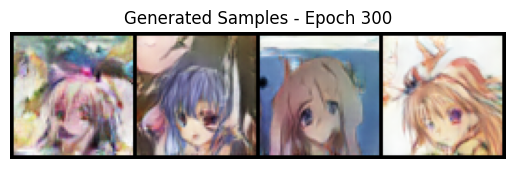

In [22]:
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples.cpu(), nrow=4, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch 300")
plt.show()

In [23]:
# pass real image into generator

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Load and preprocess the image
img_path = '/content/animeface-character-dataset/data/face_1254_484_37.png'
img = Image.open(img_path)

# Resize the image to match the expected input size of the CNN model
resize_transform = transforms.Resize((224, 224))
img_resized = resize_transform(img)

# Convert the image to a tensor and normalize it
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = normalize_transform(to_tensor_transform(img_resized)).unsqueeze(0)

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Set the model to evaluation mode
resnet.eval()

# Extract features from the image using the ResNet model
with torch.no_grad():
    features = resnet(img_tensor)

# Use a linear layer to reduce the number of channels to 128
linear_layer = torch.nn.Linear(in_features=features.size(1), out_features=128)
features_reduced = linear_layer(features.squeeze()).unsqueeze(-1).unsqueeze(-1)

# Add an extra dimension at the beginning
features_reduced = features_reduced.unsqueeze(0)

# Further processing or use of the feature map
print(features_reduced.shape)  # Output: torch.Size([1, 128, 1, 1])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 52.6MB/s]


torch.Size([1, 128, 1, 1])


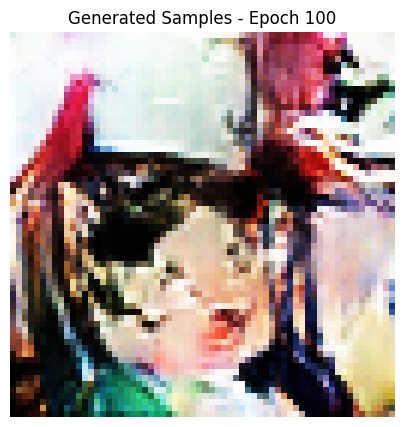

In [24]:
fake_samples = generator(features_reduced.to(device)).reshape(-1, 3, 64, 64)
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples.cpu(), nrow=4, padding=2, normalize=True)
plt.figure(figsize=(5, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()

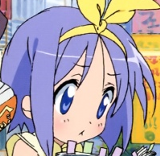

In [25]:
img